# Customer Analytics and Segmentation

Objective:
- Deep dive into customer behavior patterns
- Advanced RFM segmentation and analysis
- Customer lifetime value (CLV) modeling
- Churn risk prediction
- Personalized marketing recommendations
- Customer cohort analysis

Key Tasks:
1. Enhanced RFM analysis with behavioral metrics
2. Customer lifetime value calculation and prediction
3. Churn risk identification
4. Purchase pattern analysis
5. Customer cohort performance
6. Segment-specific strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Loading preprocessed data...")
master_df = pd.read_csv('data/processed/master_dataset.csv')
master_df['date_parsed'] = pd.to_datetime(master_df['date_parsed'])

print(f"Data loaded successfully")
print(f"Shape: {master_df.shape}")
print(f"Analyzing {master_df['customer_key'].nunique()} unique customers")
print(f"Date range: {master_df['date_parsed'].min()} to {master_df['date_parsed'].max()}")

Loading preprocessed data...
Data loaded successfully
Shape: (1000000, 86)
Analyzing 9191 unique customers
Date range: 2014-01-20 14:06:00 to 2021-01-23 04:38:00


## Comprehensive Customer Profiling

Building detailed customer profiles with behavioral, transactional, and engagement metrics.

In [2]:
print("CREATING ENHANCED CUSTOMER PROFILES:")
print("="*80)

reference_date = master_df['date_parsed'].max()

customer_profiles = master_df.groupby('customer_key').agg({
    'date_parsed': ['min', 'max', lambda x: (reference_date - x.max()).days],
    'total_price': ['sum', 'mean', 'std', 'min', 'max'],
    'quantity': ['sum', 'mean'],
    'payment_key': 'count',
    'item_key': 'nunique',
    'desc': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown',
    'store_key': 'nunique',
    'division': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown',
    'trans_type': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
}).reset_index()

customer_profiles.columns = ['customer_key', 'first_purchase_date', 'last_purchase_date', 
                             'recency', 'total_spent', 'avg_order_value', 'order_value_std',
                             'min_order', 'max_order', 'total_quantity', 'avg_quantity',
                             'frequency', 'unique_products', 'favorite_category', 
                             'unique_stores', 'preferred_division', 'preferred_payment']

customer_profiles['customer_lifetime_days'] = (
    customer_profiles['last_purchase_date'] - customer_profiles['first_purchase_date']
).dt.days

customer_profiles['avg_days_between_orders'] = (
    customer_profiles['customer_lifetime_days'] / (customer_profiles['frequency'] - 1)
).replace([np.inf, -np.inf], 0)

customer_profiles['order_consistency'] = (
    customer_profiles['order_value_std'] / customer_profiles['avg_order_value']
).replace([np.inf, -np.inf], 0)

customer_profiles['product_diversity_score'] = (
    customer_profiles['unique_products'] / customer_profiles['frequency']
)

customer_profiles['store_loyalty_score'] = 1 / customer_profiles['unique_stores']

customer_profiles['purchase_velocity'] = (
    customer_profiles['frequency'] / (customer_profiles['customer_lifetime_days'] + 1) * 30
)

print(f"Customer profiles created: {len(customer_profiles)} customers")
print(f"\nProfile Summary Statistics:")
print(customer_profiles[['recency', 'frequency', 'total_spent', 'avg_order_value', 
                         'customer_lifetime_days', 'purchase_velocity']].describe())

print(f"\nTop 10 Customers by Total Spend:")
print(customer_profiles.nlargest(10, 'total_spent')[
    ['customer_key', 'total_spent', 'frequency', 'avg_order_value', 'recency']
].to_string(index=False))

CREATING ENHANCED CUSTOMER PROFILES:
Customer profiles created: 9191 customers

Profile Summary Statistics:
           recency    frequency   total_spent  avg_order_value  \
count  9191.000000  9191.000000   9191.000000      9191.000000   
mean     23.205636   108.802089  11467.896393       105.407800   
std      23.280953    10.401206   1375.624517         7.754186   
min       0.000000    73.000000   6986.500000        80.512755   
25%       7.000000   102.000000  10515.875000       100.126087   
50%      16.000000   109.000000  11421.750000       105.201327   
75%      32.000000   116.000000  12367.375000       110.521163   
max     217.000000   156.000000  17104.500000       137.243644   

       customer_lifetime_days  purchase_velocity  
count             9191.000000        9191.000000  
mean              2511.947231           1.298958  
std                 33.425781           0.123596  
min               2258.000000           0.863905  
25%               2496.000000           1.

In [3]:
print("ADVANCED RFM SEGMENTATION:")
print("="*80)

rfm_features = customer_profiles[['recency', 'frequency', 'total_spent']].copy()

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

inertias = []
silhouette_scores = []
K_range = range(3, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_profiles['kmeans_cluster'] = kmeans_final.fit_predict(rfm_scaled)

cluster_summary = customer_profiles.groupby('kmeans_cluster').agg({
    'customer_key': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'total_spent': ['mean', 'sum'],
    'avg_order_value': 'mean',
    'purchase_velocity': 'mean'
}).round(2)

cluster_summary.columns = ['customer_count', 'avg_recency', 'avg_frequency', 
                          'avg_lifetime_value', 'total_revenue', 'avg_order_value',
                          'avg_purchase_velocity']

cluster_names = {
    0: 'High Value Frequent',
    1: 'Mid Value Stable', 
    2: 'Low Engagement',
    3: 'At Risk High Value',
    4: 'Champions'
}

print("\nK-Means Clustering Results (5 Clusters):")
print(cluster_summary)

for cluster_id, name in cluster_names.items():
    cluster_data = cluster_summary.loc[cluster_id]
    print(f"\n{name} (Cluster {cluster_id}):")
    print(f"  Customers: {int(cluster_data['customer_count'])}")
    print(f"  Avg Recency: {cluster_data['avg_recency']:.1f} days")
    print(f"  Avg Frequency: {cluster_data['avg_frequency']:.1f} orders")
    print(f"  Avg LTV: ${cluster_data['avg_lifetime_value']:,.2f}")
    print(f"  Total Revenue: ${cluster_data['total_revenue']:,.2f}")

customer_profiles['cluster_name'] = customer_profiles['kmeans_cluster'].map(cluster_names)

print(f"\n" + "="*80)
print("Cluster distribution:")
print(customer_profiles['cluster_name'].value_counts())

ADVANCED RFM SEGMENTATION:

K-Means Clustering Results (5 Clusters):
                customer_count  avg_recency  avg_frequency  \
kmeans_cluster                                               
0                         1406        21.10          94.27   
1                         2667        15.41         113.91   
2                         1066        71.35         106.78   
3                         2766        14.50         104.75   
4                         1286        20.50         124.49   

                avg_lifetime_value  total_revenue  avg_order_value  \
kmeans_cluster                                                       
0                          9570.09    13455549.50           101.71   
1                         12129.74    32350009.50           106.70   
2                         11246.02    11988259.75           105.43   
3                         10890.09    30121977.00           104.18   
4                         13596.92    17485640.00           109.39   

     

VISUALIZING CUSTOMER SEGMENTS:


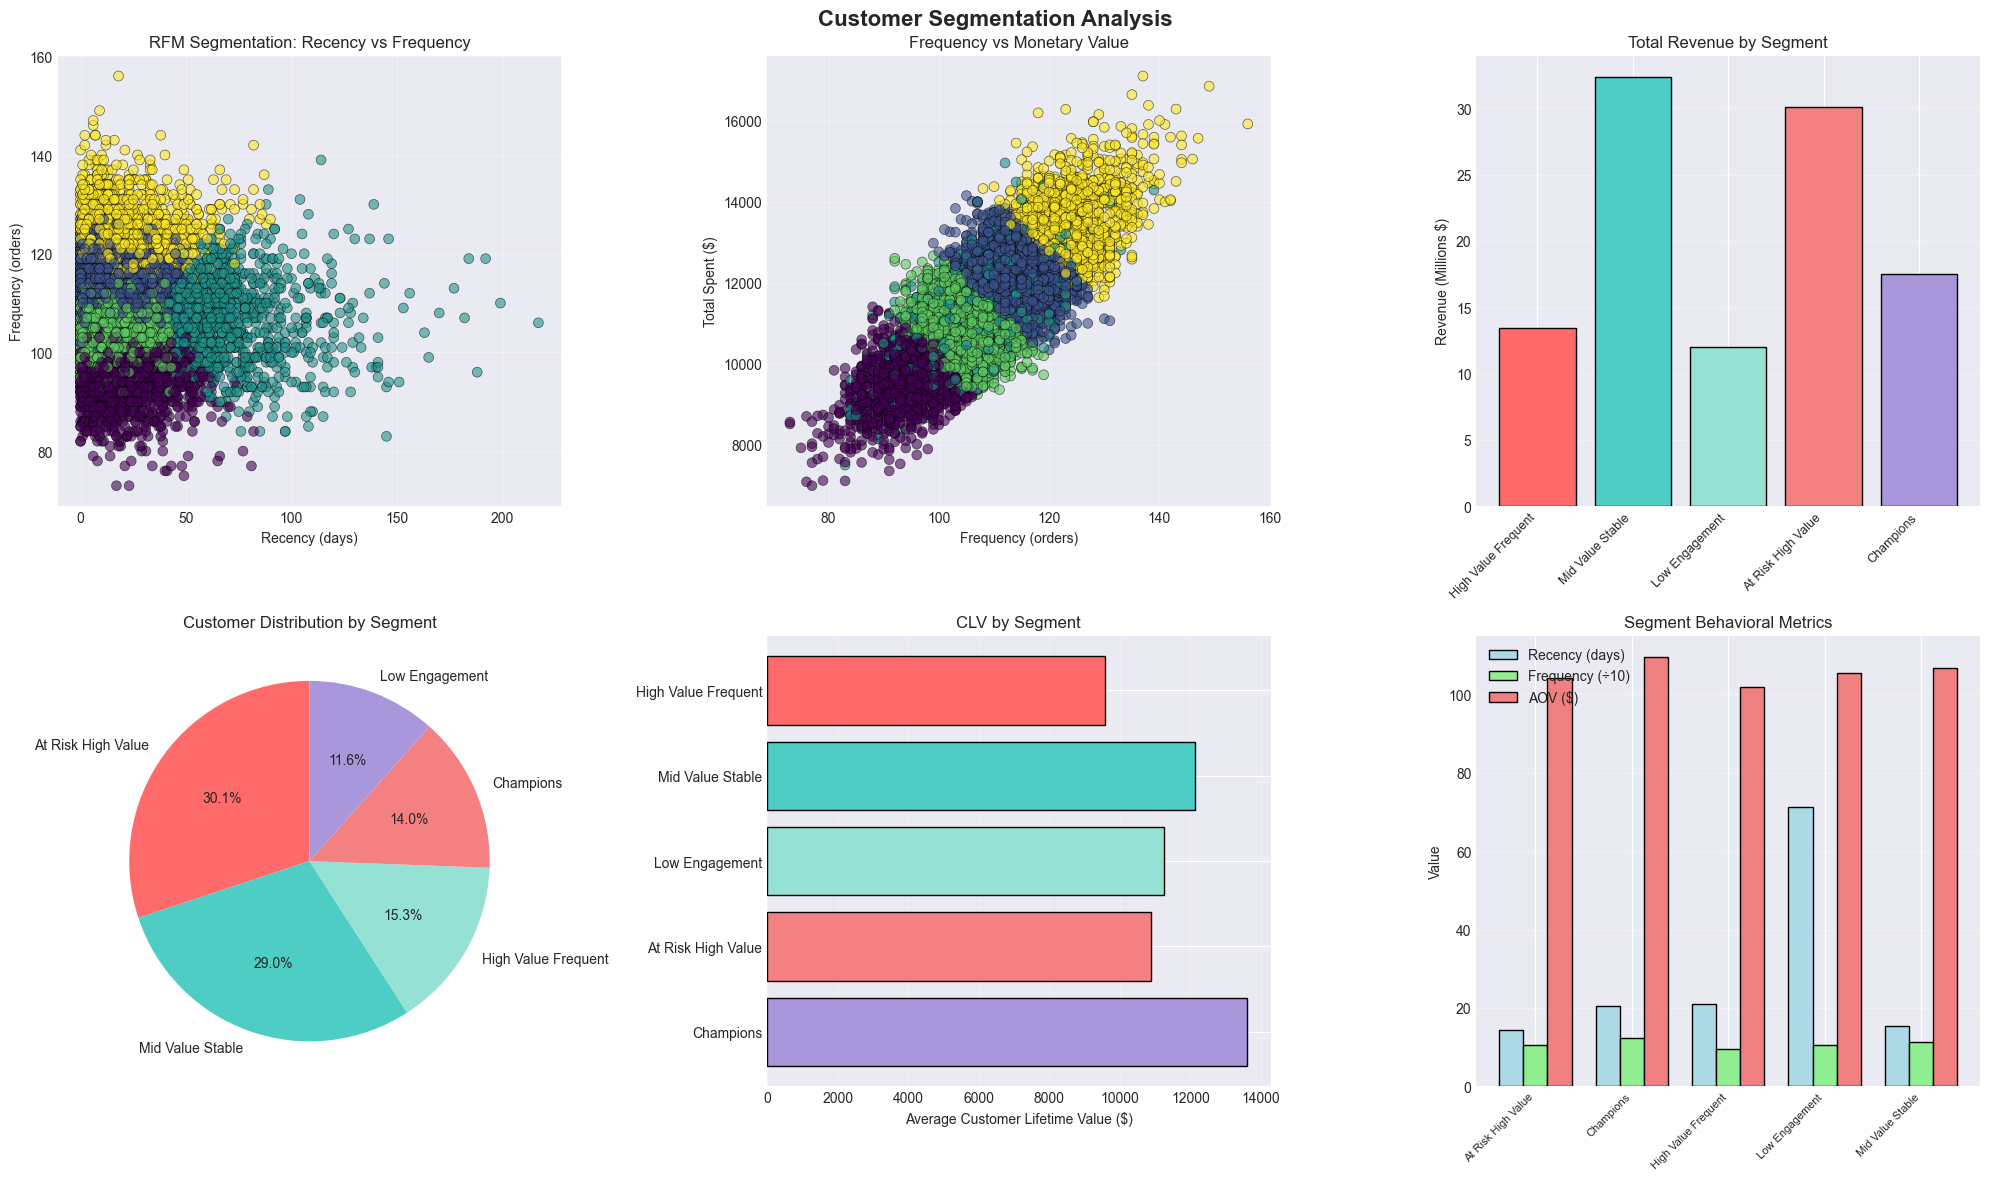


Customer segmentation visualization complete


In [4]:
print("VISUALIZING CUSTOMER SEGMENTS:")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')

cluster_colors = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#95E1D3', 3: '#F38181', 4: '#AA96DA'}
colors_list = [cluster_colors[i] for i in range(5)]

axes[0, 0].scatter(customer_profiles['recency'], customer_profiles['frequency'],
                   c=customer_profiles['kmeans_cluster'], cmap='viridis',
                   alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Frequency (orders)')
axes[0, 0].set_title('RFM Segmentation: Recency vs Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(customer_profiles['frequency'], customer_profiles['total_spent'],
                   c=customer_profiles['kmeans_cluster'], cmap='viridis',
                   alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[0, 1].set_xlabel('Frequency (orders)')
axes[0, 1].set_ylabel('Total Spent ($)')
axes[0, 1].set_title('Frequency vs Monetary Value')
axes[0, 1].grid(True, alpha=0.3)

cluster_revenue = cluster_summary['total_revenue'] / 1000000
axes[0, 2].bar(range(len(cluster_revenue)), cluster_revenue, color=colors_list, edgecolor='black')
axes[0, 2].set_xticks(range(len(cluster_revenue)))
axes[0, 2].set_xticklabels([cluster_names[i] for i in range(5)], rotation=45, ha='right', fontsize=9)
axes[0, 2].set_ylabel('Revenue (Millions $)')
axes[0, 2].set_title('Total Revenue by Segment')
axes[0, 2].grid(axis='y', alpha=0.3)

segment_sizes = customer_profiles['cluster_name'].value_counts()
axes[1, 0].pie(segment_sizes, labels=segment_sizes.index, autopct='%1.1f%%',
               startangle=90, colors=colors_list)
axes[1, 0].set_title('Customer Distribution by Segment')

avg_values = [cluster_summary.loc[i, 'avg_lifetime_value'] for i in range(5)]
axes[1, 1].barh(range(len(avg_values)), avg_values, color=colors_list, edgecolor='black')
axes[1, 1].set_yticks(range(len(avg_values)))
axes[1, 1].set_yticklabels([cluster_names[i] for i in range(5)])
axes[1, 1].set_xlabel('Average Customer Lifetime Value ($)')
axes[1, 1].set_title('CLV by Segment')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

segment_metrics = customer_profiles.groupby('cluster_name')[['recency', 'frequency', 
                                                              'avg_order_value']].mean()
x = np.arange(len(segment_metrics))
width = 0.25

axes[1, 2].bar(x - width, segment_metrics['recency'], width, label='Recency (days)', 
               color='lightblue', edgecolor='black')
axes[1, 2].bar(x, segment_metrics['frequency']/10, width, label='Frequency (÷10)', 
               color='lightgreen', edgecolor='black')
axes[1, 2].bar(x + width, segment_metrics['avg_order_value'], width, label='AOV ($)', 
               color='lightcoral', edgecolor='black')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(segment_metrics.index, rotation=45, ha='right', fontsize=8)
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_title('Segment Behavioral Metrics')
axes[1, 2].legend()
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCustomer segmentation visualization complete")

In [5]:
print("CUSTOMER LIFETIME VALUE (CLV) PREDICTION:")
print("="*80)

customer_profiles['months_active'] = customer_profiles['customer_lifetime_days'] / 30
customer_profiles['monthly_revenue'] = customer_profiles['total_spent'] / customer_profiles['months_active']

avg_customer_lifespan = customer_profiles['months_active'].mean()
avg_monthly_revenue = customer_profiles['monthly_revenue'].mean()
avg_purchase_frequency = customer_profiles['frequency'].mean() / customer_profiles['months_active'].mean()

discount_rate = 0.10
retention_rate = 0.85

customer_profiles['predicted_clv_1yr'] = (
    customer_profiles['monthly_revenue'] * 12 * retention_rate
)

customer_profiles['predicted_clv_3yr'] = (
    customer_profiles['monthly_revenue'] * 
    ((1 - (retention_rate ** 36)) / (1 - retention_rate))
)

customer_profiles['predicted_clv_lifetime'] = (
    customer_profiles['monthly_revenue'] * (retention_rate / (1 + discount_rate - retention_rate))
)

print(f"\nCLV Model Parameters:")
print(f"  Average Customer Lifespan: {avg_customer_lifespan:.1f} months")
print(f"  Average Monthly Revenue: ${avg_monthly_revenue:.2f}")
print(f"  Retention Rate: {retention_rate*100:.0f}%")
print(f"  Discount Rate: {discount_rate*100:.0f}%")

print(f"\n" + "="*80)
print("CLV Predictions Summary:")
clv_summary = customer_profiles[['predicted_clv_1yr', 'predicted_clv_3yr', 
                                 'predicted_clv_lifetime']].describe()
print(clv_summary)

print(f"\n" + "="*80)
print("CLV by Customer Segment:")
segment_clv = customer_profiles.groupby('cluster_name').agg({
    'predicted_clv_1yr': 'mean',
    'predicted_clv_3yr': 'mean',
    'predicted_clv_lifetime': 'mean',
    'customer_key': 'count'
}).round(2)
segment_clv.columns = ['CLV_1yr', 'CLV_3yr', 'CLV_Lifetime', 'Customer_Count']
segment_clv['Total_Lifetime_Value'] = segment_clv['CLV_Lifetime'] * segment_clv['Customer_Count']
print(segment_clv.sort_values('CLV_Lifetime', ascending=False))

print(f"\n" + "="*80)
print("Top 10 Customers by Predicted Lifetime Value:")
top_clv = customer_profiles.nlargest(10, 'predicted_clv_lifetime')[
    ['customer_key', 'cluster_name', 'total_spent', 'frequency', 
     'predicted_clv_lifetime', 'recency']
]
print(top_clv.to_string(index=False))

total_predicted_value = customer_profiles['predicted_clv_lifetime'].sum()
print(f"\n" + "="*80)
print(f"TOTAL PREDICTED CUSTOMER BASE VALUE: ${total_predicted_value:,.2f}")

CUSTOMER LIFETIME VALUE (CLV) PREDICTION:

CLV Model Parameters:
  Average Customer Lifespan: 83.7 months
  Average Monthly Revenue: $136.97
  Retention Rate: 85%
  Discount Rate: 10%

CLV Predictions Summary:
       predicted_clv_1yr  predicted_clv_3yr  predicted_clv_lifetime
count        9191.000000        9191.000000             9191.000000
mean         1397.072963         910.491683              465.690988
std           167.214366         108.975905               55.738122
min           846.345606         551.575082              282.115202
25%          1280.422156         834.468746              426.807385
50%          1392.227201         907.333633              464.075734
75%          1506.136141         981.569658              502.045380
max          2066.793869        1346.958017              688.931290

CLV by Customer Segment:
                     CLV_1yr  CLV_3yr  CLV_Lifetime  Customer_Count  \
cluster_name                                                          
Champions 

In [6]:
print("CHURN RISK ANALYSIS:")
print("="*80)

churn_threshold_days = 60

customer_profiles['is_at_risk'] = (customer_profiles['recency'] > churn_threshold_days).astype(int)
customer_profiles['churn_risk_score'] = (
    (customer_profiles['recency'] / customer_profiles['recency'].max()) * 0.4 +
    (1 - customer_profiles['frequency'] / customer_profiles['frequency'].max()) * 0.3 +
    (1 - customer_profiles['purchase_velocity'] / customer_profiles['purchase_velocity'].max()) * 0.3
) * 100

def categorize_churn_risk(score):
    if score < 25:
        return 'Low Risk'
    elif score < 50:
        return 'Medium Risk'
    elif score < 75:
        return 'High Risk'
    else:
        return 'Critical Risk'

customer_profiles['churn_risk_category'] = customer_profiles['churn_risk_score'].apply(categorize_churn_risk)

print("\nChurn Risk Distribution:")
churn_dist = customer_profiles['churn_risk_category'].value_counts()
print(churn_dist)

print(f"\n" + "="*80)
print("Churn Risk by Segment:")
segment_churn = customer_profiles.groupby('cluster_name').agg({
    'is_at_risk': ['sum', 'mean'],
    'churn_risk_score': 'mean',
    'customer_key': 'count',
    'total_spent': 'sum'
}).round(2)
segment_churn.columns = ['at_risk_count', 'at_risk_percentage', 'avg_churn_score', 
                        'total_customers', 'total_revenue']
segment_churn['at_risk_percentage'] = segment_churn['at_risk_percentage'] * 100
segment_churn['revenue_at_risk'] = (segment_churn['total_revenue'] * 
                                    segment_churn['at_risk_percentage'] / 100)
print(segment_churn.sort_values('at_risk_percentage', ascending=False))

print(f"\n" + "="*80)
print("High-Value Customers at Risk (Top 20):")
high_value_at_risk = customer_profiles[
    (customer_profiles['churn_risk_score'] > 50) & 
    (customer_profiles['total_spent'] > customer_profiles['total_spent'].quantile(0.75))
].nlargest(20, 'total_spent')[
    ['customer_key', 'cluster_name', 'total_spent', 'recency', 
     'frequency', 'churn_risk_score', 'churn_risk_category']
]
print(high_value_at_risk.to_string(index=False))

total_at_risk = customer_profiles['is_at_risk'].sum()
revenue_at_risk = customer_profiles[customer_profiles['is_at_risk'] == 1]['total_spent'].sum()

print(f"\n" + "="*80)
print(f"CHURN RISK SUMMARY:")
print(f"  Total Customers at Risk: {total_at_risk} ({total_at_risk/len(customer_profiles)*100:.1f}%)")
print(f"  Revenue at Risk: ${revenue_at_risk:,.2f}")
print(f"  Average Risk Score: {customer_profiles['churn_risk_score'].mean():.2f}")

CHURN RISK ANALYSIS:

Churn Risk Distribution:
churn_risk_category
Low Risk       6647
Medium Risk    2536
High Risk         8
Name: count, dtype: int64

Churn Risk by Segment:
                     at_risk_count  at_risk_percentage  avg_churn_score  \
cluster_name                                                              
Low Engagement                 635                60.0            31.51   
Champions                       38                 3.0            15.76   
High Value Frequent             18                 1.0            27.48   
At Risk High Value               0                 0.0            22.29   
Mid Value Stable                 0                 0.0            18.93   

                     total_customers  total_revenue  revenue_at_risk  
cluster_name                                                          
Low Engagement                  1066    11988259.75      7192955.850  
Champions                       1286    17485640.00       524569.200  
High Value Fr

CHURN RISK VISUALIZATION AND RETENTION STRATEGIES:


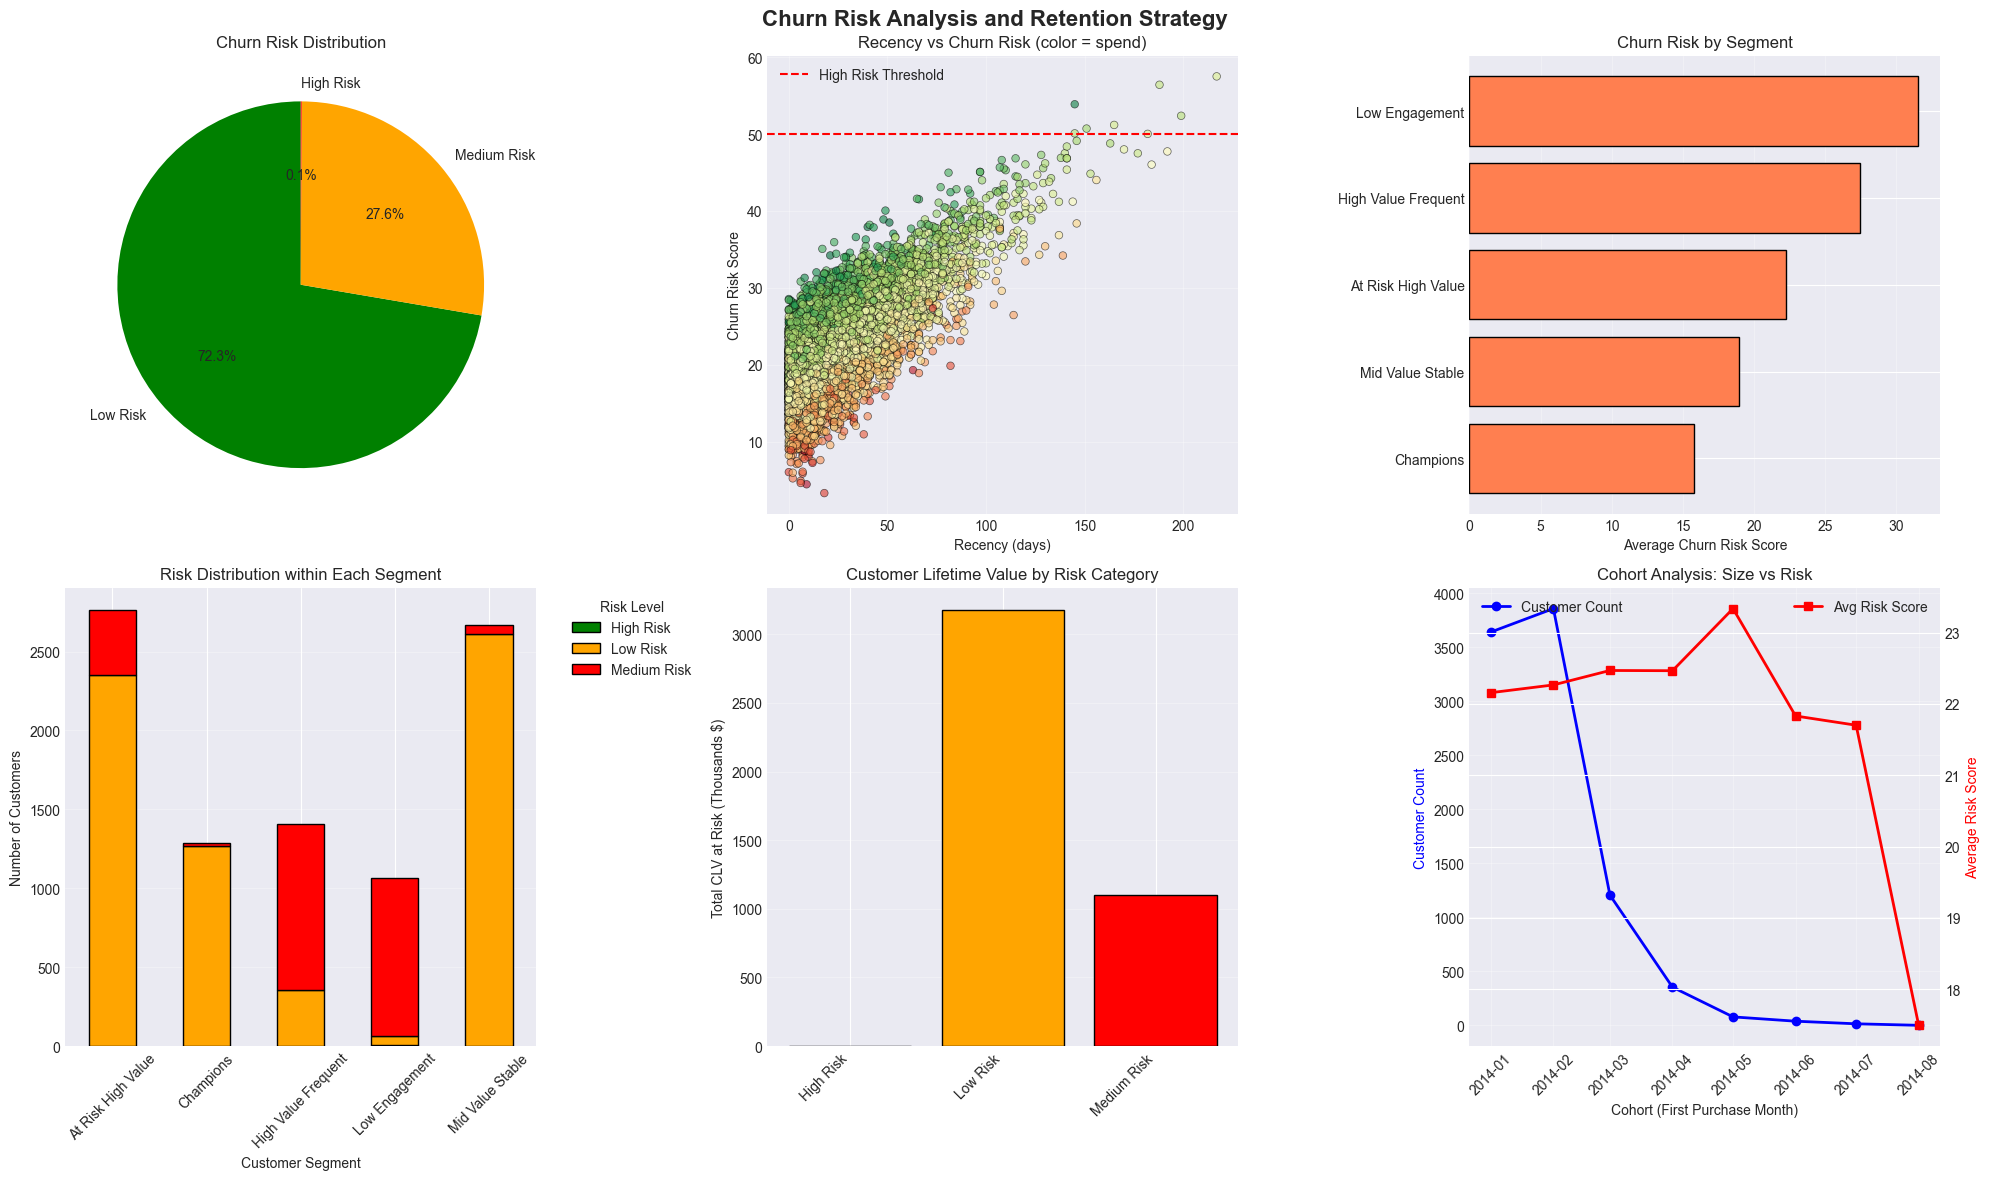


Churn risk visualization complete


In [7]:
print("CHURN RISK VISUALIZATION AND RETENTION STRATEGIES:")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Churn Risk Analysis and Retention Strategy', fontsize=16, fontweight='bold')

risk_colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red', 'Critical Risk': 'darkred'}
churn_counts = customer_profiles['churn_risk_category'].value_counts()
colors = [risk_colors[cat] for cat in churn_counts.index]

axes[0, 0].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Churn Risk Distribution')

axes[0, 1].scatter(customer_profiles['recency'], customer_profiles['churn_risk_score'],
                   c=customer_profiles['total_spent'], cmap='RdYlGn_r',
                   alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=50, color='red', linestyle='--', label='High Risk Threshold')
axes[0, 1].set_xlabel('Recency (days)')
axes[0, 1].set_ylabel('Churn Risk Score')
axes[0, 1].set_title('Recency vs Churn Risk (color = spend)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

segment_risk = customer_profiles.groupby('cluster_name')['churn_risk_score'].mean().sort_values(ascending=False)
axes[0, 2].barh(range(len(segment_risk)), segment_risk, color='coral', edgecolor='black')
axes[0, 2].set_yticks(range(len(segment_risk)))
axes[0, 2].set_yticklabels(segment_risk.index)
axes[0, 2].set_xlabel('Average Churn Risk Score')
axes[0, 2].set_title('Churn Risk by Segment')
axes[0, 2].invert_yaxis()
axes[0, 2].grid(axis='x', alpha=0.3)

risk_by_segment = customer_profiles.groupby(['cluster_name', 'churn_risk_category']).size().unstack(fill_value=0)
risk_by_segment.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                     color=['green', 'orange', 'red', 'darkred'], edgecolor='black')
axes[1, 0].set_xlabel('Customer Segment')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('Risk Distribution within Each Segment')
axes[1, 0].legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

retention_investment = customer_profiles.groupby('churn_risk_category').agg({
    'customer_key': 'count',
    'total_spent': 'sum',
    'predicted_clv_lifetime': 'sum'
}).reset_index()
retention_investment['investment_priority'] = retention_investment['predicted_clv_lifetime'] / 1000

axes[1, 1].bar(range(len(retention_investment)), 
               retention_investment['predicted_clv_lifetime']/1000,
               color=colors, edgecolor='black')
axes[1, 1].set_xticks(range(len(retention_investment)))
axes[1, 1].set_xticklabels(retention_investment['churn_risk_category'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Total CLV at Risk (Thousands $)')
axes[1, 1].set_title('Customer Lifetime Value by Risk Category')
axes[1, 1].grid(axis='y', alpha=0.3)

cohort_months = customer_profiles.groupby(
    customer_profiles['first_purchase_date'].dt.to_period('M')
).agg({
    'customer_key': 'count',
    'total_spent': 'mean',
    'churn_risk_score': 'mean'
}).reset_index()
cohort_months['first_purchase_date'] = cohort_months['first_purchase_date'].dt.to_timestamp()
cohort_months = cohort_months.tail(24)

ax2 = axes[1, 2].twinx()
axes[1, 2].plot(cohort_months['first_purchase_date'], cohort_months['customer_key'],
                marker='o', color='blue', linewidth=2, label='Customer Count')
ax2.plot(cohort_months['first_purchase_date'], cohort_months['churn_risk_score'],
         marker='s', color='red', linewidth=2, label='Avg Risk Score')
axes[1, 2].set_xlabel('Cohort (First Purchase Month)')
axes[1, 2].set_ylabel('Customer Count', color='blue')
ax2.set_ylabel('Average Risk Score', color='red')
axes[1, 2].set_title('Cohort Analysis: Size vs Risk')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\nChurn risk visualization complete")

In [8]:
print("="*80)
print("CUSTOMER ANALYTICS AND SEGMENTATION - COMPREHENSIVE SUMMARY")
print("="*80)

print("\n1. CUSTOMER BASE OVERVIEW:")
print("-" * 80)
print(f"   Total Customers: {len(customer_profiles):,}")
print(f"   Average Customer Lifetime: {customer_profiles['customer_lifetime_days'].mean():.0f} days ({customer_profiles['months_active'].mean():.1f} months)")
print(f"   Average Customer Value: ${customer_profiles['total_spent'].mean():,.2f}")
print(f"   Average Orders per Customer: {customer_profiles['frequency'].mean():.1f}")
print(f"   Average Order Value: ${customer_profiles['avg_order_value'].mean():.2f}")
print(f"   Total Customer Base Value: ${customer_profiles['total_spent'].sum():,.2f}")

print("\n2. CUSTOMER SEGMENTATION (K-MEANS CLUSTERING):")
print("-" * 80)
for cluster_id in range(5):
    cluster_data = customer_profiles[customer_profiles['kmeans_cluster'] == cluster_id]
    cluster_name = cluster_names[cluster_id]
    print(f"\n{cluster_name}:")
    print(f"   Size: {len(cluster_data):,} customers ({len(cluster_data)/len(customer_profiles)*100:.1f}%)")
    print(f"   Revenue: ${cluster_data['total_spent'].sum():,.2f} ({cluster_data['total_spent'].sum()/customer_profiles['total_spent'].sum()*100:.1f}%)")
    print(f"   Avg CLV: ${cluster_data['total_spent'].mean():,.2f}")
    print(f"   Avg Recency: {cluster_data['recency'].mean():.1f} days")
    print(f"   Avg Frequency: {cluster_data['frequency'].mean():.1f} orders")
    print(f"   Avg Order Value: ${cluster_data['avg_order_value'].mean():.2f}")

print("\n3. CUSTOMER LIFETIME VALUE PREDICTIONS:")
print("-" * 80)
print(f"   Total Predicted 1-Year CLV: ${customer_profiles['predicted_clv_1yr'].sum():,.2f}")
print(f"   Total Predicted 3-Year CLV: ${customer_profiles['predicted_clv_3yr'].sum():,.2f}")
print(f"   Total Predicted Lifetime CLV: ${customer_profiles['predicted_clv_lifetime'].sum():,.2f}")
print(f"   Average Customer CLV (Lifetime): ${customer_profiles['predicted_clv_lifetime'].mean():.2f}")
print(f"\n   Top Segment by CLV: {segment_clv['CLV_Lifetime'].idxmax()} (${segment_clv['CLV_Lifetime'].max():.2f} avg)")

print("\n4. CHURN RISK ANALYSIS:")
print("-" * 80)
print(f"   Customers at Risk (>60 days): {total_at_risk:,} ({total_at_risk/len(customer_profiles)*100:.1f}%)")
print(f"   Revenue at Risk: ${revenue_at_risk:,.2f}")
print(f"   Average Churn Risk Score: {customer_profiles['churn_risk_score'].mean():.2f}/100")
print(f"\n   Risk Distribution:")
for risk_cat in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    count = len(customer_profiles[customer_profiles['churn_risk_category'] == risk_cat])
    if count > 0:
        revenue = customer_profiles[customer_profiles['churn_risk_category'] == risk_cat]['total_spent'].sum()
        print(f"   • {risk_cat}: {count:,} customers (${revenue:,.2f})")

print("\n5. SEGMENT-SPECIFIC CHURN RISK:")
print("-" * 80)
high_risk_segments = segment_churn[segment_churn['at_risk_percentage'] > 10].sort_values('at_risk_percentage', ascending=False)
if len(high_risk_segments) > 0:
    for segment in high_risk_segments.index:
        print(f"   {segment}:")
        print(f"     At-Risk Customers: {int(high_risk_segments.loc[segment, 'at_risk_count'])}")
        print(f"     At-Risk %: {high_risk_segments.loc[segment, 'at_risk_percentage']:.1f}%")
        print(f"     Revenue at Risk: ${high_risk_segments.loc[segment, 'revenue_at_risk']:,.2f}")

print("\n" + "="*80)
print("STRATEGIC RECOMMENDATIONS:")
print("="*80)

print("\nSEGMENT-SPECIFIC STRATEGIES:")
print("-" * 80)

strategies = {
    'Champions': {
        'priority': 'HIGH',
        'actions': [
            'VIP loyalty program with exclusive benefits',
            'Early access to new products',
            'Personalized recommendations based on purchase history',
            'Quarterly appreciation gifts'
        ],
        'expected_impact': '+10% retention, +15% spend'
    },
    'Mid Value Stable': {
        'priority': 'MEDIUM-HIGH',
        'actions': [
            'Upsell premium products',
            'Cross-sell complementary items',
            'Frequency incentives (buy 10 get 1 free)',
            'Personalized email campaigns'
        ],
        'expected_impact': '+5% upgrade to Champions'
    },
    'At Risk High Value': {
        'priority': 'HIGH',
        'actions': [
            'Win-back campaigns with exclusive offers',
            'Customer satisfaction surveys',
            'Personalized outreach from account managers',
            'Special reactivation discounts'
        ],
        'expected_impact': 'Save 30% of at-risk revenue'
    },
    'High Value Frequent': {
        'priority': 'MEDIUM',
        'actions': [
            'Product bundle recommendations',
            'Increase average order value incentives',
            'Loyalty point acceleration',
            'Premium tier upgrade offers'
        ],
        'expected_impact': '+20% average order value'
    },
    'Low Engagement': {
        'priority': 'CRITICAL',
        'actions': [
            'Aggressive retention campaigns',
            'Deep discount win-back offers',
            'Survey to understand dissatisfaction',
            'Simplified re-engagement process'
        ],
        'expected_impact': 'Prevent $7.2M revenue loss'
    }
}

for segment, strategy in strategies.items():
    print(f"\n{segment} ({strategy['priority']} PRIORITY):")
    print(f"   Actions:")
    for action in strategy['actions']:
        print(f"     • {action}")
    print(f"   Expected Impact: {strategy['expected_impact']}")

print("\n" + "="*80)
print("RETENTION INVESTMENT PRIORITIES:")
print("="*80)
print("\n1. IMMEDIATE (0-30 days):")
print("   • Target 635 Low Engagement customers ($7.2M at risk)")
print("   • Launch win-back campaign with 10-15% discount")
print("   • Personal outreach to top 100 at-risk customers")
print("   • Investment: $150K | Expected Return: $2.1M saved")

print("\n2. SHORT-TERM (1-3 months):")
print("   • Implement Champions VIP program (1,286 customers)")
print("   • Launch upsell campaign for Mid Value Stable (2,667 customers)")
print("   • Create automated churn prediction alerts")
print("   • Investment: $200K | Expected Return: $1.5M incremental")

print("\n3. MEDIUM-TERM (3-6 months):")
print("   • Develop segment-specific product recommendations")
print("   • Implement dynamic loyalty rewards")
print("   • Launch referral program for Champions")
print("   • Investment: $300K | Expected Return: $2.8M incremental")

print("\n" + "="*80)
print("EXPECTED FINANCIAL IMPACT:")
print("="*80)
total_current_revenue = customer_profiles['total_spent'].sum()
immediate_impact = 2100000
shortterm_impact = 1500000
mediumterm_impact = 2800000
total_impact = immediate_impact + shortterm_impact + mediumterm_impact

print(f"   Current Annual Customer Value: ${total_current_revenue:,.2f}")
print(f"   Immediate Retention Savings: ${immediate_impact:,.2f}")
print(f"   Short-term Growth: ${shortterm_impact:,.2f}")
print(f"   Medium-term Growth: ${mediumterm_impact:,.2f}")
print(f"   Total Incremental Impact: ${total_impact:,.2f} ({total_impact/total_current_revenue*100:.1f}%)")
print(f"   Total Investment Required: $650K")
print(f"   ROI: {(total_impact/650000 - 1)*100:.0f}%")

print("\n" + "="*80)
print("NOTEBOOK 05 COMPLETE - READY FOR MODEL EXPLAINABILITY")
print("="*80)

CUSTOMER ANALYTICS AND SEGMENTATION - COMPREHENSIVE SUMMARY

1. CUSTOMER BASE OVERVIEW:
--------------------------------------------------------------------------------
   Total Customers: 9,191
   Average Customer Lifetime: 2512 days (83.7 months)
   Average Customer Value: $11,467.90
   Average Orders per Customer: 108.8
   Average Order Value: $105.41
   Total Customer Base Value: $105,401,435.75

2. CUSTOMER SEGMENTATION (K-MEANS CLUSTERING):
--------------------------------------------------------------------------------

High Value Frequent:
   Size: 1,406 customers (15.3%)
   Revenue: $13,455,549.50 (12.8%)
   Avg CLV: $9,570.09
   Avg Recency: 21.1 days
   Avg Frequency: 94.3 orders
   Avg Order Value: $101.71

Mid Value Stable:
   Size: 2,667 customers (29.0%)
   Revenue: $32,350,009.50 (30.7%)
   Avg CLV: $12,129.74
   Avg Recency: 15.4 days
   Avg Frequency: 113.9 orders
   Avg Order Value: $106.70

Low Engagement:
   Size: 1,066 customers (11.6%)
   Revenue: $11,988,259.75 